In [42]:
#imports
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
from tensorflow.keras.applications import EfficientNetB0


In [7]:
image_path = '/Users/allisonbaun/Desktop/EyeDiseaseClassification'
 

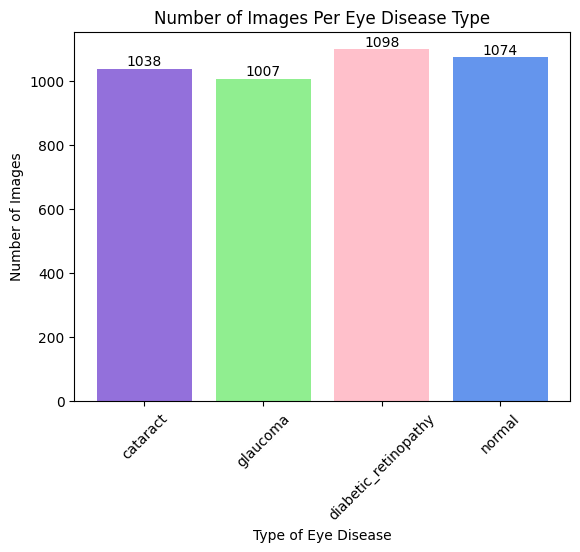

Total number of images:
4217


In [9]:
subfolders = os.listdir(image_path)

image_counts = {}

#Iterate through each folder
for folder in subfolders:
    sub_dir = os.path.join(image_path, folder)
    if os.path.isdir(sub_dir):
        image_counts[folder] = len(os.listdir(sub_dir))
        
#Extract values from disctionary 
classes = list(image_counts.keys())
counts = list(image_counts.values())

for i in range(len(classes)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')

colors = ['mediumpurple', 'lightgreen', 'pink', 'cornflowerblue']

# Plotting the results
plt.bar(classes, counts, color=colors)
plt.xlabel('Type of Eye Disease')
plt.xticks(rotation = 45)
plt.ylabel('Number of Images')
plt.title('Number of Images Per Eye Disease Type')
plt.show()

#Cross reference the counts of the images
total = 0
for i in range(len(classes)):
    total += counts[i]

print("Total number of images:")
print(total)


In [55]:
#First train and test the CNN on the original data

#Builds a CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)), #detecting features
    MaxPooling2D(2, 2), #reduce spatial dimension
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu'),  #number of filters increase with every layer to learn more complex features
    MaxPooling2D(2, 2),
    Dropout(0.3),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5), #prevent overfitting
    Dense(4, activation='softmax')  # 4 classes for glaucoma, cataract, diabetic retinopathy, normal
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [56]:
#1) Training and testing a model based on original data

# Original Data Generator without augmentation (only rescaling)
original_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training generator for original data
train_generator_original = original_datagen.flow_from_directory(
    image_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Validation generator for original data
validation_generator_original = original_datagen.flow_from_directory(
    image_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Train model on original data only
history_original = model.fit(
    train_generator_original,
    validation_data=validation_generator_original,
    epochs=50,
    callbacks=[early_stop],
    verbose=1
)

# Extract and print the final training and validation accuracy and loss
final_train_accuracy = history_original.history['accuracy'][-1]
final_val_accuracy = history_original.history['val_accuracy'][-1]
final_train_loss = history_original.history['loss'][-1]
final_val_loss = history_original.history['val_loss'][-1]

print("\nTraining Complete")
print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

Found 3376 images belonging to 4 classes.
Found 841 images belonging to 4 classes.
Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 29s 268ms/step - accuracy: 0.4138 - loss: 1.3613 - val_accuracy: 0.4625 - val_loss: 1.1894
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 29s 272ms/step - accuracy: 0.5987 - loss: 0.8970 - val_accuracy: 0.5065 - val_loss: 1.0540
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 28s 261ms/step - accuracy: 0.6655 - loss: 0.7834 - val_accuracy: 0.5351 - val_loss: 1.0330
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 28s 267ms/step - accuracy: 0.7235 - loss: 0.6798 - val_accuracy: 0.5589 - val_loss: 0.8980
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 28s 261ms/step - accuracy: 0.7504 - loss: 0.6000 - val_accuracy: 0.5386 - val_loss: 1.0768
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 29s 268ms/step - accuracy: 0.7828 - loss: 0.5651 - val_accuracy: 0.5339 - val_loss: 1.4505
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.7896 - loss: 0.5642 - val_accuracy: 0.5446 - val_loss: 1.0023
Ep

KeyboardInterrupt: 

In [54]:
# Augmented data generator for training data
train_datagen = ImageDataGenerator(
   rescale=1.0/255,         # Rescale pixel values
   rotation_range=20,       # Randomly rotate images by 20 degrees
   zoom_range=0.2,          # Randomly zoom into images
   horizontal_flip=True,    # Randomly flip images horizontally
   validation_split=0.2     # Split into 80% training and 20% validation
)


# Training generator with augmentation
train_generator = train_datagen.flow_from_directory(
   image_path,
   target_size=(128, 128),
   batch_size=32,
   class_mode='categorical',
   subset='training'  # Uses the training subset with augmentation
)

# Non-augmented data generator for validation data (only rescaling)
validation_datagen = ImageDataGenerator(
   rescale=1.0/255,         # Only rescale pixel values
   validation_split=0.2     # Split into 80% training and 20% validation
)

# Validation generator without augmentation
validation_generator = validation_datagen.flow_from_directory(
   image_path,
   target_size=(128, 128),
   batch_size=32,
   class_mode='categorical',
   subset='validation'  # Uses the validation subset without augmentation
)


#Model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)), #detecting features
    MaxPooling2D(2, 2), #reduce spatial dimension
    Conv2D(64, (3, 3), activation='relu'),  #number of filters increase with every layer to learn more complex features
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5), #prevent overfitting
    Dense(4, activation='softmax')  # 4 classes for glaucoma, cataract, diabetic retinopathy, normal
])


# Compile the model
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])


# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Train the model with augmented training data and unaugmented validation data
history = model.fit(
   train_generator,
   validation_data=validation_generator,
   epochs=30,
   callbacks=[early_stop],
   verbose=1
)

# Extract and print the final training and validation accuracy and loss
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print("\nTraining Complete")
print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")



Found 3376 images belonging to 4 classes.
Found 841 images belonging to 4 classes.
Epoch 1/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 308ms/step - accuracy: 0.3314 - loss: 1.4184 - val_accuracy: 0.4518 - val_loss: 1.2674
Epoch 2/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 310ms/step - accuracy: 0.4847 - loss: 1.1577 - val_accuracy: 0.4637 - val_loss: 1.1378
Epoch 3/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 309ms/step - accuracy: 0.5344 - loss: 1.0683 - val_accuracy: 0.5220 - val_loss: 1.0785
Epoch 4/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 318ms/step - accuracy: 0.5391 - loss: 1.0529 - val_accuracy: 0.4780 - val_loss: 1.0957
Epoch 5/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 316ms/step - accuracy: 0.5473 - loss: 1.0359 - val_accuracy: 0.4578 - val_loss: 1.1359
Epoch 6/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 314ms/step - accuracy: 0.5642 - loss: 1.0065 - val_accuracy: 0.4851 - val_loss: 1.0593
Epoch 7/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 313ms/step - accuracy: 0.5806 - loss: 0.9724 - val_accuracy: 0.4935 - val_loss: 1.0544


In [ ]:
#3) Transfer Learning 

# Load a pre-trained VGG16 model, excluding its top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze base model layers initially
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

# Define final model
transfer_model = Model(inputs=base_model.input, outputs=output)
transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# First phase: Train on original data with frozen base model
history_transfer_original = transfer_model.fit(
   train_generator_original,
   validation_data=validation_generator,
   epochs=10,  # Fewer epochs to avoid overfitting
   callbacks=[early_stop],
   verbose=1
)
# Extract and print the final training and validation accuracy and loss
final_train_accuracy = history_transfer_original.history['accuracy'][-1]
final_val_accuracy = history_transfer_original.history['val_accuracy'][-1]
final_train_loss = history_transfer_original.history['loss'][-1]
final_val_loss = history_transfer_original.history['val_loss'][-1]

print("\nTraining Complete")
print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

# Unfreeze the base model layers for fine-tuning
base_model.trainable = True
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Second phase: Fine-tune on augmented data
history_transfer_augmented = transfer_model.fit(
   train_generator_augmented,
   validation_data=validation_generator,
   epochs=20,
   callbacks=[early_stop],
   verbose=1
)

# Extract and print the final training and validation accuracy and loss
final_train_accuracy = history_transfer_augmented.history['accuracy'][-1]
final_val_accuracy = history_transfer_augmented.history['val_accuracy'][-1]
final_train_loss = history_transfer_augmented.history['loss'][-1]
final_val_loss = history_transfer_augmented.history['val_loss'][-1]

print("\nTraining Complete")
print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")



Found 3376 images belonging to 4 classes.
Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.4280 - loss: 1.2653 - val_accuracy: 0.6195 - val_loss: 0.9546
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 391s 4s/step - accuracy: 0.6722 - loss: 0.8439 - val_accuracy: 0.6730 - val_loss: 0.8096
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 104s 978ms/step - accuracy: 0.7267 - loss: 0.7037 - val_accuracy: 0.7289 - val_loss: 0.7513
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.7441 - loss: 0.6450 - val_accuracy: 0.7229 - val_loss: 0.6692
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 304s 3s/step - accuracy: 0.7676 - loss: 0.6023 - val_accuracy: 0.7360 - val_loss: 0.6628
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 501s 4s/step - accuracy: 0.7705 - loss: 0.5680 - val_accuracy: 0.7539 - val_loss: 0.5959
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 800s 8s/step - accuracy: 0.7968 - loss: 0.5339 - val_accuracy: 0.7729 - val_loss: 0.5649
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step

/opt/anaconda3/envs/artificialintel/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 534s 4s/step - accuracy: 0.6660 - loss: 0.8812 - val_accuracy: 0.6790 - val_loss: 0.7470
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 313s 3s/step - accuracy: 0.7852 - loss: 0.5618 - val_accuracy: 0.6468 - val_loss: 0.8403
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 332s 3s/step - accuracy: 0.8164 - loss: 0.4792 - val_accuracy: 0.6718 - val_loss: 0.7923
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 326s 3s/step - accuracy: 0.8497 - loss: 0.4077 - val_accuracy: 0.5553 - val_loss: 1.0988
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.8681 - loss: 0.3776 - val_accuracy: 0.5553 - val_loss: 1.2532
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 324s 3s/step - accuracy: 0.8861 - loss: 0.3295 - val_accuracy: 0.6813 - val_loss: 0.7299
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.8721 - loss: 0.3505 - val_accuracy: 0.6445 - val_loss: 0.9194
Epoch 8/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 324s 3s/step - accuracy: 0.8975 - loss: 0.2904 - val_accu

In [49]:
# Data generator for original data (no augmentation, only rescaling)
original_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

# EfficientNetB0 Model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze the base model

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train on original data
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_original = model.fit(
    train_generator_original,
    validation_data=validation_generator_original,
    epochs=20,
    callbacks=[early_stop],
    verbose=1
)

# Extract and print the final training and validation accuracy and loss
final_train_accuracy = history_original.history['accuracy'][-1]
final_val_accuracy = history_original.history['val_accuracy'][-1]
final_train_loss = history_original.history['loss'][-1]
final_val_loss = history_original.history['val_loss'][-1]

print("\nTraining Complete")
print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Compile with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune on augmented data
history_augmented = model.fit(
    train_generator_augmented,
    validation_data=validation_generator_original,
    epochs=20,
    callbacks=[early_stop],
    verbose=1
)

# Extract and print the final training and validation accuracy and loss
final_train_accuracy = history_augmented.history['accuracy'][-1]
final_val_accuracy = history_augmented.history['val_accuracy'][-1]
final_train_loss = history_augmented.history['loss'][-1]
final_val_loss = history_augmented.history['val_loss'][-1]

print("\nTraining Complete")
print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")





Epoch 1/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 27s 228ms/step - accuracy: 0.2574 - loss: 1.4475 - val_accuracy: 0.2604 - val_loss: 1.3863
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 24s 225ms/step - accuracy: 0.2596 - loss: 1.3863 - val_accuracy: 0.2604 - val_loss: 1.3861
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 24s 222ms/step - accuracy: 0.2413 - loss: 1.3862 - val_accuracy: 0.2604 - val_loss: 1.3859
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 24s 223ms/step - accuracy: 0.2537 - loss: 1.3858 - val_accuracy: 0.2604 - val_loss: 1.3858
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 23s 221ms/step - accuracy: 0.2586 - loss: 1.3865 - val_accuracy: 0.2604 - val_loss: 1.3858
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 24s 227ms/step - accuracy: 0.2587 - loss: 1.3862 - val_accuracy: 0.2604 - val_loss: 1.3858
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 24s 221ms/step - accuracy: 0.2538 - loss: 1.3863 - val_accuracy: 0.2604 - val_loss: 1.3858
Epoch 8/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 23s 218ms/step - accuracy: 0.2787 - loss: 1

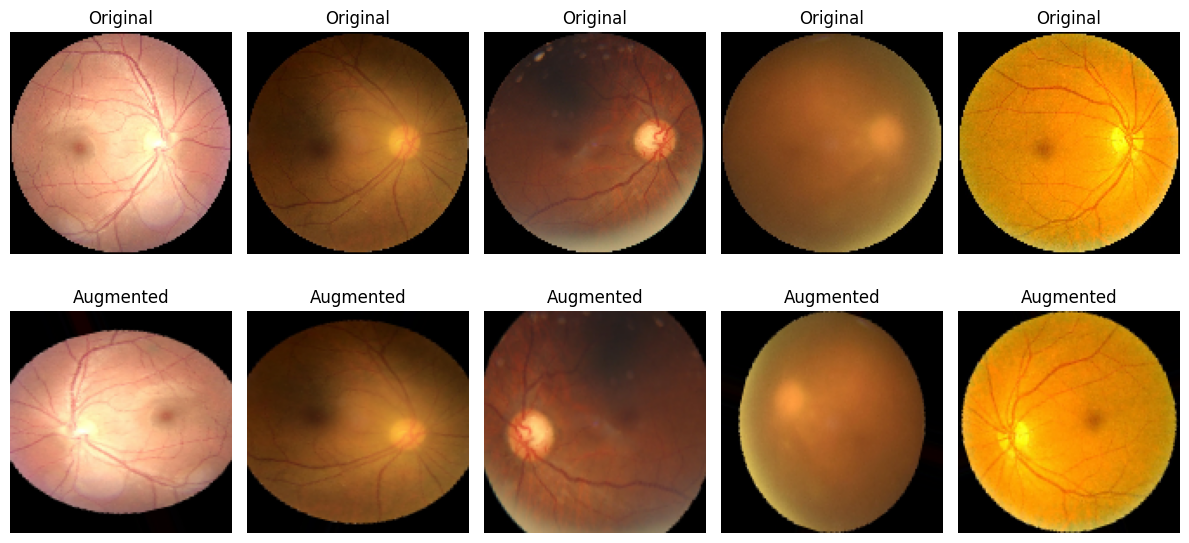

In [45]:
import random

# Number of images to display for comparison
num_images = 5

# Randomly select indices for images from the validation generator (non-augmented)
random_indices = random.sample(range(len(validation_generator.filepaths)), num_images)
original_images = [validation_generator.filepaths[i] for i in random_indices]
augmented_images = []

# Load each randomly picked original image and apply augmentation
for img_path in original_images:
    # Load original image
    img = load_img(img_path, target_size=(128, 128))
    
    # Convert image to array and apply augmentation
    augmented_img_array = train_datagen.random_transform(img_to_array(img))
    augmented_img = array_to_img(augmented_img_array / 255.0)  # Rescale for display

    augmented_images.append(augmented_img)

# Plot original and augmented images side by side
plt.figure(figsize=(12, 6))

for i in range(num_images):
    # Display original image
    plt.subplot(2, num_images, i + 1)
    plt.imshow(load_img(original_images[i], target_size=(128, 128)))
    plt.axis('off')
    plt.title("Original")

    # Display augmented image
    plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(augmented_images[i])
    plt.axis('off')
    plt.title("Augmented")

plt.tight_layout()
plt.show()
